In [126]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sn
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

In [127]:
ols_model = LinearRegression()

In [128]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1) # based on the assumption that E(epsilon|x) = 0, 
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [129]:
from scipy.stats import f as f_distrib
"""
X and Y are 3D arrays
dim 0: number of features
dim 1: number of subjects
dim 2: number of mesh nodes or voxels (numer of tests)
"""

def hotelling_t2(X, Y):

    nx = X.shape[1]
    ny = Y.shape[1]
    p = X.shape[0]
    Xbar = X.mean(1)
    Ybar = Y.mean(1)
    Xbar = Xbar.reshape(Xbar.shape[0], 1, Xbar.shape[1])
    Ybar = Ybar.reshape(Ybar.shape[0], 1, Ybar.shape[1])

    X_Xbar = X - Xbar
    Y_Ybar = Y - Ybar
    Wx = np.einsum('ijk,ljk->ilk', X_Xbar, X_Xbar)
    Wy = np.einsum('ijk,ljk->ilk', Y_Ybar, Y_Ybar)
    W = (Wx + Wy) / float(nx + ny - 2)
    Xbar_minus_Ybar = Xbar - Ybar
    x = np.linalg.solve(W.transpose(2, 0, 1),
    Xbar_minus_Ybar.transpose(2, 0, 1))
    x = x.transpose(1, 2, 0)

    t2 = np.sum(Xbar_minus_Ybar * x, 0)
    t2 = t2 * float(nx * ny) / float(nx + ny)
    stat = (t2 * float(nx + ny - 1 - p) / (float(nx + ny - 2) * p))

    pval = 1 - np.squeeze(f_distrib.cdf(stat, p, nx + ny - 1 - p))
    return t2, pval

In [130]:
"""
Input Explanation:
df_beta is the dataframe of stock betas obtained by running the first stage of BJS regression  # mat(N*K)
df_f is the dataframe of factor realizations # mat(T*K)
df_lam is the dataframe of factor risk premiums obtained by running the second stage of BJS regression # mat(T*K)
df_res is the dataframe of residuals obtained by running the first stage of BJS regression # mat(T*N)
"""

def Shanken_BJS_tstats(df_betas, df_f, df_lambdas, df_res):
    beta = df_betas
    lam = df_lambdas.mean()
    f = np.mat(df_f.T)
    res = df_res
    
    beta_mul = np.dot(np.linalg.inv(np.dot(beta.T,beta)),beta.T) #mat(K*N)
    beta_rev = np.dot(beta,np.linalg.inv(np.dot(beta.T,beta))) #mat(N*K)
    cov_res = res.cov() #mat(N*N)
    beta_mul_res = np.dot(np.dot(beta_mul, cov_res),beta_rev) #mat(K*K)
    cov_f = np.mat(np.cov(f)) #mat(K*K)
    c = pd.DataFrame(1+np.dot(np.dot(lam,np.linalg.inv(cov_f)),lam.T)) #c is a coefficient 
    
    adj_cov = (1/len(df_f))*(beta_mul_res*c.values+cov_f) #mat(K*K)
    se = np.sqrt(np.diagonal(adj_cov))
    t_stats = lam.values/se
    return t_stats

In [131]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [132]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [133]:
## Newey-West Adjustment For a Time-Series Data, e.g. Lambdas (factor returns)
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Import Data

In [134]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)
df_MR.index = pd.to_datetime(df_MR.index)

Import risk-free rate (91-day T-Bill)

In [135]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [136]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])
df_SR.index = pd.to_datetime(df_SR.index)

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [137]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

In [138]:
df_SR.dropna(axis=1)

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,ACL.SJ.Equity,...,AFE.SJ.Equity,DSY.SJ.Equity,MRP.SJ.Equity,APN.SJ.Equity,AFX.SJ.Equity,SUR.SJ.Equity,DRD.SJ.Equity,SUI.SJ.Equity,WBO.SJ.Equity,SNT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.012821,-0.024693,-0.040734,-0.009132,-0.004376,-0.016666,-0.048790,-0.025318,-0.079755,-0.013234,...,0.000000,-0.004491,0.000000,0.000000,-0.013889,0.000000,-0.020201,-0.020620,-0.040822,0.000000
2000-01-06,0.075623,-0.077962,-0.047886,0.015175,-0.015470,0.024898,-0.021053,0.011332,-0.015207,0.034932,...,0.034689,-0.018187,0.000000,-0.024698,0.020762,0.000000,-0.031094,0.000000,0.000000,-0.032789
2000-01-07,0.079437,0.013423,0.034816,0.041304,0.011808,0.032262,0.004246,0.068053,0.033902,0.147389,...,0.100805,-0.086180,0.007117,0.060625,0.020340,0.021979,0.031094,0.010363,0.020619,0.003325
2000-01-10,0.066809,0.089231,0.076001,0.020973,0.100433,0.023531,0.000000,0.071096,0.016530,0.043488,...,0.000000,0.014887,0.021053,0.045994,0.036248,0.000000,0.005086,0.000000,0.010152,0.043874
2000-01-11,0.020203,0.070618,-0.050029,-0.044366,0.003312,-0.012481,-0.044182,-0.055430,-0.009151,-0.090891,...,-0.017275,-0.004934,0.000000,0.220877,-0.003241,0.021506,0.000000,0.006167,0.010050,0.017337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-27,-0.000119,0.004612,0.003673,0.012542,0.003590,0.004883,0.009022,-0.001472,0.025673,-0.080043,...,-0.027909,0.010917,0.007941,0.010903,0.005886,-0.030334,0.027399,0.011287,-0.010159,-0.021661


Calculate the Excess Stock Returns 

In [139]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [140]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)
df_FF3.index = pd.to_datetime(df_FF3.index)

In [141]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)
df_FF4.index = pd.to_datetime(df_FF4.index)
df_FF4_tmp = pd.read_csv("df_FF4_tmp.csv")
df_FF4["WML"] = df_FF4_tmp["WML"].values
df_FF4

,MR_RF,SMB,HML,WML
Dates,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0068
2000-12-21,-0.0062,0.0030,-0.0000,-0.0062
2000-12-22,0.0163,-0.0085,-0.0026,-0.0005
2000-12-25,-0.0003,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000
...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0033
2019-02-28,-0.0055,0.0014,-0.0185,-0.0077
2019-03-01,0.0034,-0.0035,0.0113,0.0007


In [142]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)
df_FF5.index = pd.to_datetime(df_FF5.index)

Import Firm Characteristics 

In [143]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size = df_ln_Size.replace([np.inf, -np.inf], np.nan)
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)
df_ln_Size.index = pd.to_datetime(df_ln_Size.index)

In [144]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE = df_PE.replace([np.inf, -np.inf], np.nan)
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)
df_PE.index = pd.to_datetime(df_PE.index)
df_EP = 1/df_PE

In [145]:
df_PB = pd.read_csv('df_std_PB.csv')
df_PB = df_PB.replace([np.inf, -np.inf], np.nan)
df_PB.Dates = df_PB.Dates.apply(lambda x:x[:10])
df_PB.set_index('Dates',inplace=True)
df_PB.index = pd.to_datetime(df_PB.index)
df_BM = 1/df_PB

In [146]:
df_MOM = pd.read_csv('df_std_MOM.csv')
df_MOM = df_MOM.replace([np.inf, -np.inf], np.nan)
df_MOM = df_MOM.iloc[:,1:]
df_MOM.set_index('Dates',inplace=True)
df_MOM.index = pd.to_datetime(df_MOM.index)

Import 18 double-sorted portfolios returns

In [147]:
df_12_PR = pd.read_csv('df_12_PR.csv')
df_12_PR = df_12_PR.iloc[:,1:]
df_12_PR.Dates = df_12_PR.Dates.apply(lambda x:x[:10])
df_12_PR.set_index('Dates',inplace=True)
df_12_PR.index = pd.to_datetime(df_12_PR.index)

Import Firm Characteristics of 12 double-sorted portfolios

In [148]:
df_12_std_Size = pd.read_csv('df_12_std_size.csv')
df_12_std_Size = df_12_std_Size.iloc[:,1:].replace([np.inf, -np.inf], np.nan)
df_12_std_Size.Dates = df_12_std_Size.Dates.apply(lambda x:x[:10])
df_12_std_Size.set_index('Dates',inplace=True)
df_12_std_Size.index = pd.to_datetime(df_12_std_Size.index)

In [149]:
df_12_std_PE = pd.read_csv('df_12_std_PE.csv')
df_12_std_PE  = df_12_std_PE .iloc[:,1:].replace([np.inf, -np.inf], np.nan)
df_12_std_PE.Dates = df_12_std_PE.Dates.apply(lambda x:x[:10])
df_12_std_PE.set_index('Dates',inplace=True)
df_12_std_PE.index = pd.to_datetime(df_12_std_PE.index)
df_12_std_EP = 1/df_12_std_PE

In [150]:
df_12_std_PB = pd.read_csv('df_12_std_PB.csv')
df_12_std_PB  = df_12_std_PB.iloc[:,1:].replace([np.inf, -np.inf], np.nan)
df_12_std_PB.Dates = df_12_std_PB.Dates.apply(lambda x:x[:10])
df_12_std_PB.set_index('Dates',inplace=True)
df_12_std_PB.index = pd.to_datetime(df_12_std_PB.index)
df_12_std_BM = 1/df_12_std_PB
df_12_std_BM = df_12_std_BM.fillna(0)

In [151]:
df_12_std_MOM = pd.read_csv('df_12_std_MOM.csv')
df_12_std_MOM  = df_12_std_MOM.iloc[:,1:].replace([np.inf, -np.inf], np.nan)
df_12_std_MOM.Dates = df_12_std_MOM.Dates.apply(lambda x:x[:10])
df_12_std_MOM.set_index('Dates',inplace=True)
df_12_std_MOM.index = pd.to_datetime(df_12_std_MOM.index)

# Winsorization

In [152]:
df_Ex_SR = df_Ex_SR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [153]:
df_FF3 = df_FF3.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF4 = df_FF4.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF5 = df_FF5.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_MR = df_MR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [154]:
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.066746,-0.000279,-0.000279,0.010867,-0.047144,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.066746,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.051113,0.116362,0.050048,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.051113,0.044575,-0.049104,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.060519,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


In [155]:
## In Fama&French (2020), they use firm characteristics as factor loadings and then conduct TS and CS regression to 
## test the explanatory power of pure factor returns. And then they compare these two new FF5CS-Factor asset pricing models with 
## the traditional FF5TS-Factor Model(2015).

## Compare TS and CS Models

### Time-Series Factor Model I

In [156]:
## Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment
## Step-2: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [157]:
df_FF4_tmp2 = df_FF4.drop(columns="SMB")

In [158]:
df_FF4_tmp2

,MR_RF,HML,WML
Dates,,,
2000-12-20,-0.0083,0.0128,0.0068
2000-12-21,-0.0062,-0.0000,-0.0062
2000-12-22,0.0163,-0.0026,-0.0005
2000-12-25,-0.0003,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000
...,...,...,...
2019-02-27,0.0008,0.0017,-0.0033
2019-02-28,-0.0055,-0.0168,-0.0077
2019-03-01,0.0034,0.0113,0.0007


In [159]:
# FF5-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:].dropna(axis=1)

all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []
all_resid = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []
resid = []

for j in tqdm(df_Ex_SR_trnct.columns):

        lag = int(4*((len(df_Ex_SR_trnct.loc[:, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[:, j].astype(np.float64), sm.add_constant(
            df_FF4.astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        rsd = res.resid
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)
        resid.append(rsd)

all_resid.append(pd.DataFrame(resid))
all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 73/73 [00:00<00:00, 207.90it/s]


In [160]:
TS_resid = all_resid[0].T
TS_resid.columns = df_Ex_SR_trnct.columns
TS_resid

,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.015376,-0.000014,0.035971,0.003183,0.012804,0.029026,0.039422,0.010581,0.002836,0.040974,...,-0.004003,-0.000475,0.000972,0.041701,0.000585,0.012235,0.002461,0.006437,0.041949,-0.003867
2000-12-21,-0.011370,0.002720,-0.016377,-0.003975,-0.009115,-0.006475,-0.015078,0.000092,-0.006192,0.057261,...,0.000841,0.001299,0.023927,0.044552,-0.012870,-0.004054,-0.012677,0.000566,-0.035229,-0.007662
2000-12-22,0.048526,-0.011373,-0.011179,0.004315,-0.018962,0.038059,0.019314,0.008842,0.026869,-0.039969,...,-0.001147,-0.004510,0.084564,-0.046163,-0.004991,-0.002658,0.010352,-0.004171,0.026627,-0.004486
2000-12-25,0.000175,-0.000269,-0.000389,-0.000092,0.000063,0.000064,0.000169,0.000339,0.000155,-0.000332,...,-0.000323,-0.000269,-0.001128,-0.000764,-0.000270,-0.000348,-0.000627,-0.000901,-0.000545,-0.001096
2000-12-26,0.000175,-0.000269,-0.000389,-0.000092,0.000063,0.000064,0.000169,0.000339,0.000155,-0.000332,...,-0.000323,-0.000269,-0.001128,-0.000764,-0.000270,-0.000348,-0.000627,-0.000901,-0.000545,-0.001096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.000863,-0.001289,-0.017288,-0.001058,0.017460,-0.009774,-0.012976,0.038459,-0.006844,0.002065,...,-0.003251,-0.011808,-0.116093,0.058356,0.020731,-0.015302,-0.002108,-0.032279,-0.001090,0.003471
2019-02-28,-0.005633,0.291259,0.000563,-0.002195,0.012652,0.006919,-0.008103,0.072984,0.022621,-0.013610,...,-0.055728,0.017016,-0.097504,0.014620,-0.009115,0.021107,0.005479,-0.005937,0.001138,-0.001870
2019-03-01,-0.060576,-0.227736,0.000798,0.004209,-0.008360,-0.007532,0.024475,-0.049449,0.024483,-0.009908,...,0.045586,0.035847,0.001263,-0.003352,0.008723,-0.013168,-0.002907,0.005555,-0.000215,-0.020060


In [161]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CSB.SJ.Equity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     29.45
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           3.16e-24
Time:                        01:38:08   Log-Likelihood:                 11834.
No. Observations:                4750   AIC:                        -2.366e+04
Df Residuals:                    4745   BIC:                        -2.363e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.106      0.002       0.000       0.001
MR_RF          0.2477      0.035      7.080      0.000       0.179       0.316
SMB            0.0044      0.058      0.077      0.939      -0.109       0.118
HML            0.2034      0.049      4.132      0.000       0.107       0.300
WML            0.3120      0.065      4.829      0.000       0.185       0.439
==============================================================================
Omnibus:                      791.421   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3720.945
Skew:                           0.731   Prob(JB):                         0.00
Kurtosis:                       7.082   Cond. No.                         213.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
"""

In [162]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','WML','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,WML
Stocks,,,,,
MTN.SJ.Equity,-0.000189,0.843541,-0.549533,0.016902,-0.063561
AEG.SJ.Equity,0.000186,0.614121,-0.289436,0.050138,-0.242801
NTC.SJ.Equity,0.000252,0.433694,-0.428808,0.003193,0.092579
WHL.SJ.Equity,-0.000035,0.466671,-0.643626,-0.091878,0.332875
SOL.SJ.Equity,0.000009,1.128812,-0.015170,-0.028401,-0.167468
...,...,...,...,...,...
SNT.SJ.Equity,0.000143,0.205853,-0.251241,-0.033812,0.135193
CLH.SJ.Equity,0.000408,0.160871,-0.139853,-0.094314,0.046737
HDC.SJ.Equity,0.000712,0.258092,0.093604,0.077473,0.036126


In [163]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    73.000000
mean      0.000237
std       0.000674
min      -0.000328
25%      -0.000063
50%       0.000099
75%       0.000306
max       0.004292
Name: Intercepts, dtype: float64

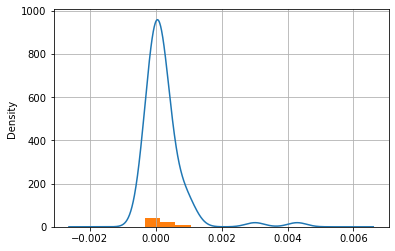

In [164]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [165]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
MTN.SJ.Equity,0.000247
AEG.SJ.Equity,0.000856
NTC.SJ.Equity,0.000199
WHL.SJ.Equity,0.000210
SOL.SJ.Equity,0.000208
...,...
SNT.SJ.Equity,0.000186
CLH.SJ.Equity,0.000199
HDC.SJ.Equity,0.000242


In [166]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
MTN.SJ.Equity,-0.763313
AEG.SJ.Equity,0.216960
NTC.SJ.Equity,1.268763
WHL.SJ.Equity,-0.167293
SOL.SJ.Equity,0.042051
...,...
SNT.SJ.Equity,0.765535
CLH.SJ.Equity,2.051761
HDC.SJ.Equity,2.942406


#### Results_1

In [167]:
GRS_test(df_FF4,TS_resid,TS_alphas)

(2.094841223953288, 1.9144225626988032e-07)

In [168]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))
### The mis-pricing errros is about 0.04% daily return, which is strongly significant

0.7368488535867117 0.9834621158621132


In [169]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = df_Ex_SR_trnct.mean().var()
print(np.mean(np.square(TS_alphas))/cs_var)

1.0144753496004666


In [170]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values),axis=0).values
print(A_lamda/cs_var)

[0.78009543]


In [171]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.11681211191975802 As(a): 0.0013659748763883467 As(e): 0.09272136511674668


In [172]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(TS_alphas)/np.var(df_Ex_SR_trnct.mean()))

0.08578276413580477

### Cross-section Factor Model I

In [173]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t+beta,i*lambda,t), t=1,2,3,...,T, Vi
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [174]:
## Import 18 double-sorted portfolios returns

In [175]:
ols_model = LinearRegression()

In [176]:
df_12_PR

,B_Value,B_Neutral_PB,B_Growth,B_Winner,B_Neutral_MOM,B_Loser,S_Value,S_Neutral_PB,S_Growth,S_Winner,S_Neutral_MOM,S_Loser
Dates,,,,,,,,,,,,
2000-12-20,0.0062,-0.0079,-0.0224,0.0032,-0.0061,-0.0223,-0.0047,-0.0152,-0.0002,0.0023,-0.0013,-0.0066
2000-12-21,-0.0069,-0.0137,0.0022,-0.0023,0.0006,-0.0191,-0.0008,0.0087,-0.0100,-0.0036,-0.0024,0.0016
2000-12-22,0.0112,0.0131,0.0143,0.0132,0.0137,0.0144,0.0058,0.0027,0.0070,0.0098,0.0034,0.0047
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0060,-0.0002,0.0051,0.0012,0.0000,0.0076,0.0037,-0.0017,0.0023,0.0083,0.0000,0.0013
2019-02-28,-0.0089,-0.0058,0.0014,-0.0086,0.0000,0.0018,-0.0059,-0.0029,0.0019,-0.0122,0.0000,-0.0020
2019-03-01,0.0047,0.0011,-0.0033,-0.0004,0.0000,0.0012,-0.0012,0.0043,-0.0042,-0.0061,0.0000,0.0023


In [177]:
len(df_12_std_Size)==len(df_12_std_BM)==len(df_12_std_MOM)==len(df_12_PR)

True

In [178]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt
## and four pure factor returns at each time t;

In [193]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_12_PR.T.columns)

for k in tqdm(df_12_PR.T.columns):
    # k is time t in 4750 days

        l = list(ols_model.fit((pd.concat([df_12_std_Size.T.loc[:, k],
                                           df_12_std_PE.T.loc[:, k],
                                           df_12_std_MOM.T.loc[:, k]], axis=1).values),
                               (df_12_PR.T.loc[:, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_12_std_Size.T.loc[:, k],
                                      df_12_std_PE.T.loc[:, k],
                                      df_12_std_MOM.T.loc[:, k]], axis=1).values),
                          (df_12_PR.T.loc[:,k].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:13<00:00, 354.86it/s]


In [194]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','BM',"MOM",'Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,BM,MOM
Dates,,,
2000-12-20,-0.000790,0.000112,0.004949
2000-12-21,-0.001023,-0.000360,0.002016
2000-12-22,0.003753,0.000404,-0.000275
2000-12-25,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000
...,...,...,...
2019-02-27,-0.000039,0.001040,0.000416
2019-02-28,-0.001218,0.003728,-0.000559
2019-03-01,0.001188,-0.001934,-0.001727


In [195]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.006250
2000-12-21,-0.003808
2000-12-22,0.009442
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.002800
2019-02-28,-0.003433
2019-03-01,-0.000133


In [196]:
df_12_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_12_CS

,Rzt,Size,BM,MOM
Dates,,,,
2000-12-20,-0.006250,-0.000790,0.000112,0.004949
2000-12-21,-0.003808,-0.001023,-0.000360,0.002016
2000-12-22,0.009442,0.003753,0.000404,-0.000275
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.002800,-0.000039,0.001040,0.000416
2019-02-28,-0.003433,-0.001218,0.003728,-0.000559
2019-03-01,-0.000133,0.001188,-0.001934,-0.001727


In [197]:
df_12_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,BM,MOM
0,1.920895,-0.064810,-2.350471,6.271390e+00
1,0.054805,0.948328,0.018790,3.896105e-10


In [59]:
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, Vi

In [60]:
# ## (average beta) * lambda + Rz
# index = df_MOM.index
# Prediction = df_ln_Size.loc[index,:].apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,0])+\
# df_PE.loc[index,:].apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,1])+\
# df_MOM.loc[index,:].apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,2])

In [61]:
# beta * lambda + Rz
index = df_MOM.index
Prediction = df_ln_Size.loc[index,:].apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_PE.loc[index,:].apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_MOM.loc[index,:].apply(lambda x: x * df_CS_FF4.iloc[:,2])

In [62]:
Prediction

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.004143,-0.012576,-0.000790,-0.008952,0.000383,NaN,0.002310,-0.014871,-0.001254,0.000875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.002335,-0.005175,-0.002673,-0.002865,-0.000035,NaN,0.001255,-0.006389,-0.000745,-0.000956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.004813,0.003451,0.009572,-0.003171,0.001836,NaN,-0.000391,0.003006,0.002278,0.007483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,-0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,-0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.000310,-0.000062,-0.000339,-0.000073,-0.002615,-0.000086,0.000536,-0.000106,-0.000329,-0.000152,...,-0.001369,-0.000032,-0.000134,NaN,NaN,NaN,-0.000155,-0.000455,-0.000123,-0.000105
2019-02-28,-0.002116,-0.000924,-0.001968,-0.000659,0.003204,-0.001794,0.000235,0.000180,-0.002362,-0.003686,...,0.000640,-0.001298,-0.001265,NaN,NaN,NaN,-0.001543,-0.000551,-0.001249,-0.001011
2019-03-01,0.000640,-0.000097,0.003352,-0.000395,0.009605,0.000759,-0.000133,-0.001334,0.002332,0.002387,...,0.004537,0.000328,0.000335,NaN,NaN,NaN,0.000364,0.001932,0.000073,0.000458


In [63]:
intc_index = df_SR.loc[df_MOM.index,:].index.intersection(Prediction.index)
intc_columns = df_SR.loc[df_MOM.index,:].columns.intersection(Prediction.columns)

In [64]:
df_SR.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.011211,-0.117783,-0.026088,0.0,-0.007551,0.000000,0.030772,-0.057759,-0.003556,0.002107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.049637,-0.068993,-0.017778,0.0,0.000000,-0.013129,-0.020409,-0.055570,-0.010633,-0.014847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.044758,0.017700,0.073467,0.0,0.001541,0.000000,0.000000,0.055570,0.017697,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.000829,NaN,0.000000,NaN,-0.017486,NaN,-0.002816,0.019041,...,0.045120,0.003494,-0.057679,NaN,0.014148,0.052096,0.000000,0.006645,0.006842,0.043952
2019-02-28,NaN,NaN,-0.010837,NaN,0.288878,NaN,-0.002748,NaN,-0.006529,0.008386,...,-0.019803,0.000498,0.006231,-0.009097,0.015452,0.007431,0.009941,0.000000,0.000000,-0.006689
2019-03-01,NaN,NaN,-0.055638,NaN,-0.288878,NaN,0.004315,NaN,0.007396,-0.004710,...,0.000000,-0.000498,-0.006231,-0.064075,0.036975,-0.006652,0.006275,0.001985,0.014291,-0.018629


In [65]:
## After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of 
## CS factor models by using real stock time subtract its corresponding prediction return


In [66]:
df_alphas = df_SR.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas = df_alphas.loc[:,TS_alphas.index]
df_alphas

Stocks,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.019048,-0.001683,0.034712,0.003948,0.007483,NaN,0.036076,-0.009309,0.004879,NaN,...,NaN,0.005373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.011297,0.003843,-0.017856,-0.006081,-0.010082,NaN,-0.015653,-0.002976,-0.003767,NaN,...,NaN,0.002550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.054454,-0.009736,-0.009051,0.005977,-0.016924,NaN,0.024644,0.018339,0.023614,NaN,...,NaN,-0.006884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.003290,-0.000185,-0.020823,-0.005287,0.016393,-0.012353,-0.014327,0.036508,-0.009612,0.000714,...,-0.004816,-0.013069,-0.117684,0.048341,0.018265,-0.018344,-0.004441,-0.033597,-0.002265,0.001721
2019-02-28,-0.005435,0.289107,0.000451,-0.000734,0.015505,0.006379,-0.005679,0.094830,0.026455,0.003356,...,-0.057355,0.017462,-0.095217,0.013698,-0.005129,0.025103,0.010169,-0.003260,0.003870,-0.003833
2019-03-01,-0.058857,-0.298349,0.004581,0.005197,-0.006964,-0.003508,0.026776,-0.047613,0.025717,-0.014987,...,0.050121,0.037754,0.002852,-0.001187,0.011589,-0.012979,-0.003363,0.007446,-0.000974,-0.017682


In [67]:
## The Newey-West Adjustment is used to avoid the time-series autocorrelation of alphas

In [68]:
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [69]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas

Stocks
MTN.SJ.Equity    0.000121
AEG.SJ.Equity   -0.000941
NTC.SJ.Equity    0.000460
WHL.SJ.Equity    0.000373
SOL.SJ.Equity    0.000252
                   ...   
SNT.SJ.Equity    0.000384
CLH.SJ.Equity    0.000376
HDC.SJ.Equity    0.000331
BEL.SJ.Equity   -0.000149
CSB.SJ.Equity    0.000745
Length: 73, dtype: float64

In [70]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

Stocks,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
0,0.421662,-1.607666,1.994231,1.613704,0.971635,1.581797,0.142116,-0.222372,-0.41331,-0.29134,...,0.409418,0.486996,-0.598666,1.85031,0.06201,1.615192,1.715725,1.36327,-0.261274,2.614965


In [71]:
# calculate the percentage of NAs in 
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.0136986301369863

In [72]:
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

#### Results_2

In [73]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

0.5752880090320295 0.9450783567938146


In [74]:
### Step3: Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = df_Ex_SR_trnct.mean().var()
print(np.mean(np.square(TSmean_alphas))/cs_var)

0.23298112389359307


In [75]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.std()/np.sqrt(len(df_MOM))
A_lamda = np.mean(pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values),axis=0)
print(A_lamda/cs_var)

0    0.01129
dtype: float64


In [76]:
## loop the above procedure
SST = df_SR.var()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [77]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR.loc[intc_index,intc_columns].apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [78]:
R_sqrt.describe()

count    72.000000
mean      0.999819
std       0.000023
min       0.999789
25%       0.999799
50%       0.999817
75%       0.999837
max       0.999906
dtype: float64

In [79]:
# alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
# alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))
alpha_sds = df_alphas.std()
alpha_ses = alpha_sds/np.sqrt(len(df_MOM))

In [80]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.19428119439846567 As(a): 0.0014232771231421487 As(e): 0.09809260626563049


In [81]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR_trnct.mean()))

0.820705143725996

### Cross-section Factor Model II

In [82]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [83]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,BM,MOM
Dates,,,
2000-12-20,-0.000790,0.000112,0.004949
2000-12-21,-0.001023,-0.000360,0.002016
2000-12-22,0.003753,0.000404,-0.000275
2000-12-25,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000
...,...,...,...
2019-02-27,-0.000039,0.001040,0.000416
2019-02-28,-0.001218,0.003728,-0.000559
2019-03-01,0.001188,-0.001934,-0.001727


In [84]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [85]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
# df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MR_RF,Size,BM,MOM
Dates,,,,
2000-12-20,-0.0083,-0.000790,0.000112,0.004949
2000-12-21,-0.0062,-0.001023,-0.000360,0.002016
2000-12-22,0.0163,0.003753,0.000404,-0.000275
2000-12-25,-0.0003,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.0008,-0.000039,0.001040,0.000416
2019-02-28,-0.0055,-0.001218,0.003728,-0.000559
2019-03-01,0.0034,0.001188,-0.001934,-0.001727


In [86]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MR_RF,Size,BM,MOM
month,,,,
2000-12,0.0107,0.002662,0.002153,0.011910
2001-01,0.0727,0.002857,-0.020737,-0.007826
2001-02,-0.0068,-0.009042,-0.007137,0.024243
2001-03,-0.0890,-0.021243,-0.016242,0.022467
2001-04,0.0921,0.015037,-0.002772,0.002273
...,...,...,...,...
2018-11,-0.0365,-0.011079,0.003791,0.020595
2018-12,0.0375,-0.001882,0.001840,0.005635
2019-01,0.0234,0.013500,-0.001423,0.000570


In [87]:
m_df_CS_FF5.mean()*100

MR_RF    0.644955
Size    -0.005903
BM      -0.140107
MOM      0.428873
dtype: float64

In [88]:
m_df_CS_FF5.std()

MR_RF    0.045755
Size     0.011349
BM       0.008601
MOM      0.010805
dtype: float64

In [89]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,Size,BM,MOM
0,2.090738,-0.077150,-2.416273,5.887366e+00
1,0.037705,0.938575,0.016500,1.460909e-08


In [90]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MR_RF,Size,BM,MOM
0,1.896746,-0.064810,-2.350471,6.271390e+00
1,0.057922,0.948328,0.018790,3.896105e-10


In [91]:
df_CS_FF5.corr()

,MR_RF,Size,BM,MOM
MR_RF,1.000000,0.607481,-0.023569,0.002849
Size,0.607481,1.000000,-0.147450,-0.009565
BM,-0.023569,-0.147450,1.000000,0.040743
MOM,0.002849,-0.009565,0.040743,1.000000


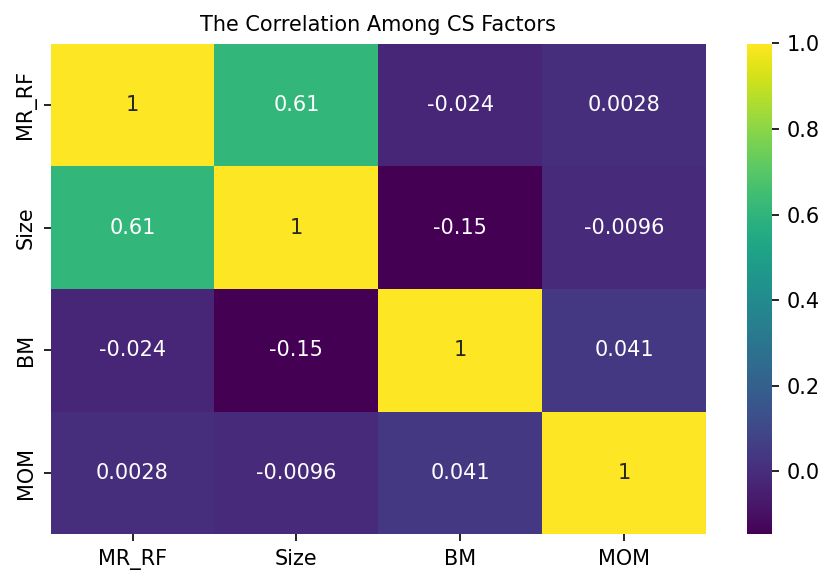

In [92]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [93]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR.loc[df_CS_FF5.index, :].dropna(axis=1)

all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []
all_resid = []
all_cons_ts = []

betas = []
labels = []
std_errs = []
cons_ts = []
Rs = []
sd_res = []
resid = []

for j in tqdm(df_Ex_SR_trnct.columns):

    lag = int(4*((len(df_Ex_SR_trnct.loc[:, j]))/100)**(1/9))
    ols = sm.OLS(df_Ex_SR_trnct.loc[:, j].astype(np.float64), sm.add_constant(
        df_CS_FF5.astype(np.float64)))
    res = ols.fit()
    res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    b = list(res.params)
    se = list(res.bse)
    t = res.tvalues[0]
    r = res.rsquared
    sr = res.resid.std()
    rsd = res.resid
    betas.append(b)
    std_errs.append(se)
    Rs.append(r)
    sd_res.append(sr)
    cons_ts.append(t)
    labels.append(j)
    resid.append(rsd)

all_resid.append(pd.DataFrame(resid))
all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))
all_cons_ts.append(pd.DataFrame(cons_ts))

100%|██████████| 73/73 [00:00<00:00, 242.90it/s]


In [94]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CSB.SJ.Equity   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     25.80
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           3.48e-21
Time:                        01:30:56   Log-Likelihood:                 11828.
No. Observations:                4750   AIC:                        -2.365e+04
Df Residuals:                    4745   BIC:                        -2.361e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.671      0.000       0.001       0.002
MR_RF          0.2097      0.037      5.671      0.000       0.137       0.282
Size           0.3668      0.147      2.497      0.013       0.079       0.655
BM            -0.6936      0.182     -3.814      0.000      -1.050      -0.337
MOM           -0.0597      0.184     -0.324      0.746      -0.420       0.301
==============================================================================
Omnibus:                      800.371   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3810.116
Skew:                           0.736   Prob(JB):                         0.00
Kurtosis:                       7.133   Cond. No.                         549.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
"""

In [95]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','BM',"MOM",'Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,BM,MOM
Stocks,,,,,
MTN.SJ.Equity,-0.000020,0.769247,1.438074,-0.118579,-0.330905
AEG.SJ.Equity,0.000355,0.440218,1.489632,-0.202788,-0.888438
NTC.SJ.Equity,0.000391,0.392045,1.085874,-0.133878,0.016176
WHL.SJ.Equity,0.000205,0.424960,1.590528,0.051055,0.269076
SOL.SJ.Equity,0.000038,1.070481,0.317975,0.415196,-0.351178
...,...,...,...,...,...
SNT.SJ.Equity,0.000284,0.159175,0.814841,0.163827,-0.022812
CLH.SJ.Equity,0.000456,0.128591,0.475970,0.182765,-0.001349
HDC.SJ.Equity,0.000690,0.220838,0.074062,-0.166001,0.230348


In [96]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas

Stocks
MTN.SJ.Equity   -0.000020
AEG.SJ.Equity    0.000355
NTC.SJ.Equity    0.000391
WHL.SJ.Equity    0.000205
SOL.SJ.Equity    0.000038
                   ...   
SNT.SJ.Equity    0.000284
CLH.SJ.Equity    0.000456
HDC.SJ.Equity    0.000690
BEL.SJ.Equity    0.000340
CSB.SJ.Equity    0.001100
Name: Intercepts, Length: 73, dtype: float64

In [97]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','BM',"MOM",'Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,BM,MOM
Stocks,,,,,
MTN.SJ.Equity,0.000249,0.039423,0.145906,0.167825,0.143919
AEG.SJ.Equity,0.000868,0.066188,0.325273,0.303118,0.341330
NTC.SJ.Equity,0.000198,0.031187,0.121771,0.150610,0.115673
WHL.SJ.Equity,0.000210,0.037642,0.162254,0.187130,0.159790
SOL.SJ.Equity,0.000206,0.031056,0.118355,0.140452,0.124725
...,...,...,...,...,...
SNT.SJ.Equity,0.000184,0.030448,0.131097,0.156225,0.143931
CLH.SJ.Equity,0.000198,0.025630,0.105499,0.121123,0.110358
HDC.SJ.Equity,0.000241,0.032269,0.128226,0.143632,0.131490


In [98]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    73.000000
mean      0.000299
std       0.000173
min       0.000150
25%       0.000209
50%       0.000247
75%       0.000315
max       0.001214
Name: Intercepts, dtype: float64

In [99]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    73.000000
mean      0.855038
std       1.216356
min      -1.070219
25%      -0.043833
50%       0.600568
75%       1.545757
max       3.860232
Name: Intercepts, dtype: float64

In [100]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
MTN.SJ.Equity,-0.081660
AEG.SJ.Equity,0.409290
NTC.SJ.Equity,1.976727
WHL.SJ.Equity,0.975161
SOL.SJ.Equity,0.182424
...,...
SNT.SJ.Equity,1.545757
CLH.SJ.Equity,2.305197
HDC.SJ.Equity,2.860295


#### Results_3

In [101]:
GRS_test(df_CS_FF5,pd.DataFrame(all_resid[0].T),alphas)

(2.154704155501021, 5.949737857946502e-08)

In [102]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))
### The mis-pricing errros is about 0.8% daily return, which is strongly significant

0.8167854710342365 1.1355925806591811


In [103]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = df_Ex_SR_trnct.mean().var()
print(np.mean(np.square(alphas))/cs_var)

1.162074819599992


In [104]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values),axis=0)
print(A_lamda/cs_var)

0    0.922705
dtype: float64


In [105]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.11598475021863579 As(a): 0.0013720104197487647 As(e): 0.09279707207894543


In [106]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR_trnct.mean()))

0.011466820534834943

In [107]:
stats.ttest_1samp(df_12_CS,0)

Ttest_1sampResult(statistic=array([ 1.92089477, -0.06481002, -2.35047126,  6.27139012]), pvalue=array([5.48047787e-02, 9.48327991e-01, 1.87903438e-02, 3.89610506e-10]))

In [108]:
df_12_CS.std()*np.sqrt(252)*100

Rzt     7.196008
Size    4.615610
BM      3.020512
MOM     3.465301
dtype: float64

In [109]:
(np.exp(np.mean(df_12_CS,axis=0)*252)-1)*100

Rzt     3.235047
Size   -0.068877
BM     -1.621970
MOM     5.133022
dtype: float64

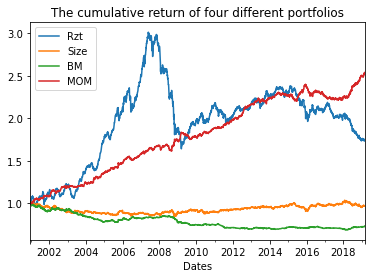

In [110]:
(df_12_CS.iloc[:,:]+1).cumprod().plot(title = "The cumulative return of four different portfolios")
plt.show()

In [111]:
df_12_CS.columns = ['Rzt', 'MC', 'BM', 'MOM']

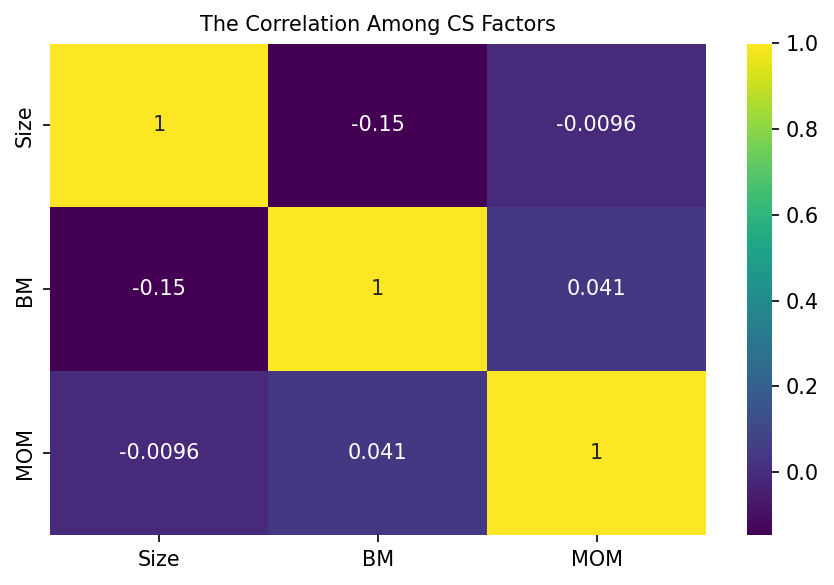

In [112]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF4.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()